# PAMTRA example on airborne measurements and ICON-LEM data

Here we give an example on how to use PAMTRA for a comparison between airborne measured radar reflectivities and brightness temperatures and modeled quantities. The application of such a task can be an evaluation of the cloud resolving model ICON-LEM by airborne measurements.

To run the example some input data is required data directory:

 * ICON with microphysical parameterization performing good: https://uni-koeln.sciebo.de/s/XHMxsXVd1a9yuy9
 * ICON with worse parameterization: https://uni-koeln.sciebo.de/s/vB68jXc97mj8VPn
 * MiRAC measurements: https://uni-koeln.sciebo.de/s/NjCuST5GCd1fcDX

Start with importing the required libraries and setting up the Notebook to show plots inline.

In [1]:
import numpy as np
import pyPamtra

Define the hydrometeor description for the six hydrometeors of the ICON-LEM microphysical scheme.

In [2]:
descriptorFile = np.array([
        #['hydro_name' 'as_ratio' 'liq_ice' 'rho_ms' 'a_ms' 'b_ms' 'alpha_as' 'beta_as' 'moment_in' 'nbin' 'dist_name' 'p_1' 'p_2' 'p_3' 'p_4' 'd_1' 'd_2' 'scat_name' 'vel_size_mod' 'canting']
        ('cwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   2.0,    1.0,   2.0e-6,   8.0e-5, 'mie-sphere', 'corPowerLaw_24388657.6_2.0', -99.0),
        ('iwc_q', 1.0, -1, -99.0, 1.58783,  2.56,  0.684,   2.0, 13, 100, 'mgamma', -99.0, -99.0, 1.564, 0.8547, 1.744e-5, 9.369e-3, 'ssrg-rt3',   'corPowerLaw_30.606_0.5533',  -99.0),
        ('rwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   2.0,    1.0,  0.00012,   8.2e-3, 'mie-sphere', 'corPowerLaw_494.74_0.7031',  -99.0),
        ('swc_q', 0.6, -1, -99.0,   0.038,   2.0, 0.3971,  1.88, 13, 100, 'mgamma', -99.0, -99.0,   1.0,    1.0,  5.13e-5, 2.294e-2, 'ssrg-rt3',   'corPowerLaw_5.511054_0.25',  -99.0),
        ('gwc_q', 1.0, -1, -99.0,  500.86,  3.18,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,  5.37,   1.06,  2.11e-4,   1.3e-2, 'mie-sphere', 'corPowerLaw_406.67_0.85',    -99.0),
        ('hwc_q', 1.0, -1, -99.0,  392.33,   3.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   5.0,    1.0,  1.87e-4,   1.1e-2, 'mie-sphere', 'corPowerLaw_106.33_0.5',     -99.0)],
        dtype=[('hydro_name', 'S15'), ('as_ratio', '<f8'), ('liq_ice', '<i8'), ('rho_ms', '<f8'), ('a_ms', '<f8'), ('b_ms', '<f8'), ('alpha_as', '<f8'), ('beta_as', '<f8'), ('moment_in', '<i8'), ('nbin', '<i8'), ('dist_name', 'S15'), ('p_1', '<f8'), ('p_2', '<f8'), ('p_3', '<f8'), ('p_4', '<f8'), ('d_1', '<f8'), ('d_2', '<f8'), ('scat_name', 'S20'), ('vel_size_mod', 'S30'), ('canting', '<f8')] 
        )

In [3]:
iconFile = 'data/acloud_icon_input.nc'

In [4]:
pam = pyPamtra.importer.readIcon2momOnFlightTrack(iconFile, descriptorFile)

/home/dori/lib/python/pyPamtra/core.py:820: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:837: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:837: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:837: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:847: Warning: sfc_type set to -9999
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:847: Warning: sfc_model set to -9999
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:858: Warning: sfc_refl set to S
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:870: Warning: ob

In [5]:
pam.p['sfc_type'] = np.zeros(pam._shape2D)
pam.p['sfc_model'] = np.zeros(pam._shape2D)
pam.p['sfc_refl'] = np.chararray(pam._shape2D)
pam.p['sfc_refl'][pam.p['sfc_type'] == 0] = 'F'
pam.p['obs_height'][:,0] = 3000.

Set up everything for the active calculation.

In [6]:
pam.nmlSet['radar_attenuation'] = 'top-down' # include attenuation by gas and hydrometeors

In [7]:
pam.nmlSet['passive'] = False # switch off passive calculations

Now run PAMTRA for 94 GHz in parallel mode by making chunks of 10 profiles in x direction (pp_deltaX=10) and using all available cores (pp_local_workers="auto").

In [8]:
pam.runParallelPamtra(94.,pp_deltaX=10, pp_deltaY=1, pp_deltaF=1, pp_local_workers="auto")

Define output file and store active results to it.

In [9]:
outFileAct = 'data/pamtra_icon_active.nc'

In [10]:
pam.writeResultsToNetCDF(outFileAct)

Set up everything for passive calculation.

In [11]:
pam.nmlSet['passive'] = True
pam.nmlSet['active'] = False

Run PAMTRA in parallel mode for 89 GHz passive to produce brightness temperatures.

In [12]:
pam.runParallelPamtra([89., 243., 340.],pp_deltaX=10, pp_deltaY=1, pp_deltaF=1, pp_local_workers="auto")

Define output file and store results.

In [13]:
outFilePas = 'data/pamtra_icon_passive.nc'

In [14]:
pam.writeResultsToNetCDF(outFilePas)

In [15]:
oldiconFile = 'data/first_acloud_icon_input.nc'
pam = pyPamtra.importer.readIcon2momOnFlightTrack(oldiconFile, descriptorFile)
pam.p['sfc_type'] = np.zeros(pam._shape2D)
pam.p['sfc_model'] = np.zeros(pam._shape2D)
pam.p['sfc_refl'] = np.chararray(pam._shape2D)
pam.p['sfc_refl'][pam.p['sfc_type'] == 0] = 'F'
pam.p['obs_height'][:,0] = 3000.
pam.nmlSet['radar_attenuation'] = 'top-down' # include attenuation by gas and hydrometeors
pam.nmlSet['passive'] = False # switch off passive calculations
pam.runParallelPamtra(94.,pp_deltaX=10, pp_deltaY=1, pp_deltaF=1, pp_local_workers="auto")
oldoutFileAct = 'data/first_pamtra_icon_active.nc'
pam.writeResultsToNetCDF(oldoutFileAct)
pam.nmlSet['passive'] = True
pam.nmlSet['active'] = False
pam.runParallelPamtra([89., 243., 340.],pp_deltaX=10, pp_deltaY=1, pp_deltaF=1, pp_local_workers="auto")
oldoutFilePas = 'data/first_pamtra_icon_passive.nc'
pam.writeResultsToNetCDF(oldoutFilePas)

## Now it's time for plotting
To plot the data we need to read in the observations and the two active and passive simulations.

In [16]:
import pickle #  load pickle module to read the mirac data

In [17]:
with open('data/mirac.pkl', 'rb') as input:
    Ze, tb89, tb243, tb340, lon, alt, lon_tb = pickle.load(input)

In [18]:
from netCDF4 import Dataset
pamtraa = dict()
ncpam = Dataset('data/pamtra_icon_active.nc')
pamtraa['Ze'] = ncpam.variables['Ze'][:]
pamtraa['height'] = ncpam.variables['height'][:]
pamtraa['longitude'] = ncpam.variables['longitude'][:]
pamtraa['latitude'] = ncpam.variables['latitude'][:]
ncpam.close()

pamtrap = dict()
ncpam = Dataset('data/pamtra_icon_passive.nc')
pamtrap['tb'] = ncpam.variables['tb'][:]
pamtrap['longitude'] = ncpam.variables['longitude'][:]
pamtrap['latitude'] = ncpam.variables['latitude'][:]
ncpam.close()

pamtraa2 = dict()
ncpam = Dataset('data/first_pamtra_icon_active.nc')
pamtraa2['Ze'] = ncpam.variables['Ze'][:]
pamtraa2['height'] = ncpam.variables['height'][:]
pamtraa2['longitude'] = ncpam.variables['longitude'][:]
pamtraa2['latitude'] = ncpam.variables['latitude'][:]
ncpam.close()

pamtrap2 = dict()
ncpam = Dataset('data/first_pamtra_icon_passive.nc')
pamtrap2['tb'] = ncpam.variables['tb'][:]
pamtrap2['longitude'] = ncpam.variables['longitude'][:]
pamtrap2['latitude'] = ncpam.variables['latitude'][:]
ncpam.close()

Import plotting modules and set up inline plotting. 

In [19]:
import matplotlib.pyplot as plt

In [20]:
import numpy as np

In [21]:
%matplotlib inline

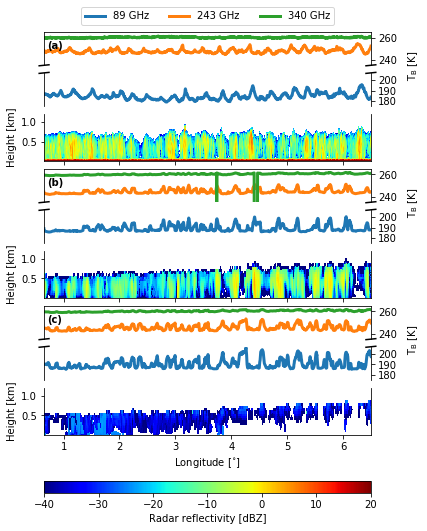

In [22]:
width_inch=6.72441
height_inch=8

fnts = 8
tfnts = 10
lfnts = 10

def make_diag(ax_up,ax_lo):
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax_up.transAxes, color='k', clip_on=False)
    ax_up.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax_up.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax_lo.transAxes)  # switch to the bottom axes
    ax_lo.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax_lo.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    return

def arange_plot(axt,axm,axb):

    axt.spines['bottom'].set_visible(False)
    axt.tick_params(bottom=False)
    axt.yaxis.tick_right()
    axt.set_xlim(xlims)
    axt.set_ylim(y1lims)

    axm.spines['top'].set_visible(False)
    axm.spines['bottom'].set_visible(False)
    axm.tick_params(labeltop=False)
    axm.yaxis.tick_right()
    axm.set_ylim(y2lims)
    axm.tick_params(bottom=False)
    axm.set_yticks(y2ticks)
    axm.set_xlim(xlims)
    axm.set_ylabel('$\mathrm{T_B}$ [K]', fontsize=lfnts)
    axm.yaxis.set_label_coords(1.15, 1.2, transform=axm.transAxes)

    make_diag(axt,axm)

    axb.set_ylim([0.,h])
    axb.set_yticks(y3ticks)
    axb.spines['top'].set_visible(False)
    axb.set_xlim(xlims)
    axb.set_ylabel('Height [km]',fontsize=lfnts)

    return

#fig = plt.figure()

gs_kw = dict()
gs_kw['right'] = 0.8
gs_kw['bottom'] = 0.2
gs_kw['top'] = 0.9
gs_kw['height_ratios'] = [.7,.7,1.,.7,.7,1.,.7,.7,1.]
fig, (ax1, ax2, ax3,ax4,ax5,ax6, ax7, ax8, ax9) = plt.subplots(9,1,sharex=True, gridspec_kw=gs_kw, figsize=(width_inch, height_inch))

ze_min, ze_max = [-40.,20]
xlims = [0.65,6.5]
y1lims = [235.,265.]
y2lims = [175.,207.]

y1ticks = [0.5,1.0]
y2ticks = [180,190,200]
y3ticks = [0.5,1.0]
h = 1.2

ax1.plot(lon_tb[:],tb243[:],lw=3,color='tab:orange',label='243 GHz')
ax1.plot(lon_tb[:],tb340[:],lw=3,color='tab:green',label='340 GHz')

ax2.plot(lon, tb89,lw=3,label='89 GHz')

ZeM = np.ma.masked_where(Ze == -999.,Ze)
ZeM = np.ma.masked_invalid(ZeM)
pcm = ax3.pcolormesh(lon,alt/1.e3,10.*np.log10(ZeM.T),vmin=ze_min,vmax=ze_max,cmap='jet')

ax1.annotate('(a)',(0.01,0.5), xycoords='axes fraction',fontweight='bold')

arange_plot(ax1,ax2,ax3)

handles, labels = [(a + b) for a, b in zip(ax2.get_legend_handles_labels(), ax1.get_legend_handles_labels())]
fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.9),loc='upper center', bbox_transform=ax1.transAxes,ncol=3)


longitude = np.zeros((pamtraa['longitude'].shape[0],pamtraa['height'].shape[2]))
longitude = np.repeat(pamtraa['longitude'],pamtraa['height'].shape[2],axis=1)
pc = ax6.pcolormesh(longitude[:,:],pamtraa['height'][:,0,:]/1.e3,pamtraa['Ze'][:,0,:,0,0,0],vmin=ze_min,vmax=ze_max,cmap='jet')

ax5.plot(pamtraa['longitude'],pamtrap['tb'][:,0,0,4,0,1],lw=3)
ax4.plot(pamtraa['longitude'],pamtrap['tb'][:,0,0,0,1,1],color='tab:orange',lw=3)
ax4.plot(pamtraa['longitude'],pamtrap['tb'][:,0,0,0,2,1],color='tab:green',lw=3)

arange_plot(ax4,ax5,ax6)

ax4.annotate('(b)',(0.01,0.5), xycoords='axes fraction',fontweight='bold')

pc = ax9.pcolormesh(longitude[:,:],pamtraa2['height'][:,0,:]/1.e3,pamtraa2['Ze'][:,0,:,0,0,0],vmin=ze_min,vmax=ze_max,cmap='jet')

ax8.plot(pamtraa['longitude'],pamtrap2['tb'][:,0,0,4,0,1],lw=3)
ax7.plot(pamtraa['longitude'],pamtrap2['tb'][:,0,0,0,1,1],color='tab:orange',lw=3)
ax7.plot(pamtraa['longitude'],pamtrap2['tb'][:,0,0,0,2,1],color='tab:green',lw=3)

arange_plot(ax7,ax8,ax9)

ax7.annotate('(c)',(0.01,0.5), xycoords='axes fraction',fontweight='bold')

ax9.set_xlabel('Longitude [$^{\circ}$]',fontsize=lfnts)
ax_box = ax9.get_position()
axm_box = ax1.get_position()
cax = fig.add_axes([ax_box.x0, ax_box.y0-0.1, ax_box.width, 0.02], rasterized=True)
cbar = ax9.get_figure().colorbar(pc, ax=ax9, cax=cax,orientation='horizontal')       
cbar.set_label('Radar reflectivity [dBZ]', fontsize=lfnts)
cbar.ax.tick_params(labelsize=10)